# Part 1 : Scrap Wikipedia Data

Download wikipedia data

In [2]:
!wget -q -O 'postal.html' https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

Parse the data using BeautifulSoup

In [3]:
from bs4 import BeautifulSoup

with open('postal.html', encoding='utf-8') as html_doc:   # utf-8
    soup = BeautifulSoup(html_doc, 'html.parser')

The required data is in `td` tag

In [4]:
soup('td')[:10]

[<td>M1A</td>, <td>Not assigned</td>, <td>Not assigned
 </td>, <td>M2A</td>, <td>Not assigned</td>, <td>Not assigned
 </td>, <td>M3A</td>, <td><a href="/wiki/North_York" title="North York">North York</a></td>, <td><a href="/wiki/Parkwoods" title="Parkwoods">Parkwoods</a>
 </td>, <td>M4A</td>]

Add all `td` in a numpy array.  Stop when found empty string. Resize the array to create a data frame

In [5]:
import numpy as np

a = []
for tag in soup('td'):
    s = tag.text.strip()
    if s == '': break
    a.append(s)
    
a = np.array(a)
print(a.shape)
a = a.reshape((-1,3))
print(a.shape)

(867,)
(289, 3)


Create a DataFrame

In [6]:
import pandas as pd

df = pd.DataFrame(a)   # if dict is used, the column name would not be in this order
df.columns = ['PostalCode', 'Borough', 'Neighborhood']
df.head()

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


Check missing data

In [7]:
print(((df.Borough == 'Not assigned') & (df.Neighborhood == 'Not assigned')).sum())
print(((df.Borough != 'Not assigned') & (df.Neighborhood == 'Not assigned')).sum())
print(((df.Borough == 'Not assigned') & (df.Neighborhood != 'Not assigned')).sum())

77
1
0


Remove missing data

In [8]:
df = df[(df.Borough != 'Not assigned') | (df.Neighborhood != 'Not assigned')]

s = df[df.Neighborhood == 'Not assigned'].Borough
df.loc[df.Neighborhood == 'Not assigned', 'Neighborhood'] = s

df.head(10)

,PostalCode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights
7,M6A,North York,Lawrence Manor
8,M7A,Queen's Park,Queen's Park
10,M9A,Etobicoke,Islington Avenue
11,M1B,Scarborough,Rouge
12,M1B,Scarborough,Malvern


In [9]:
df.shape

(212, 3)

In [12]:
!conda install -c conda-forge geocoder --yes

Solving environment: done

## Package Plan ##

  environment location: /opt/ibm/conda/miniconda3

  added / updated specs: 
    - geocoder


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geocoder-1.38.1            |             py_0          52 KB  conda-forge
    ratelim-0.1.6              |           py35_0           5 KB  conda-forge
    ca-certificates-2018.8.24  |       ha4d7672_0         136 KB  conda-forge
    conda-4.5.11               |           py35_0         636 KB  conda-forge
    certifi-2018.8.24          |           py35_1         138 KB  conda-forge
    openssl-1.0.2p             |       h470a237_0         3.5 MB  conda-forge
    orderedset-2.0             |           py35_0         685 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         5.1 MB

The following NEW packages will be INS

In [13]:
import geocoder

def get_location(postal_code):
  # initialize your variable to None
  lat_lng_coords = None
    
  # loop until you get the coordinates
  while(lat_lng_coords is None):
    g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))
    lat_lng_coords = g.latlng
  
  return pd.Series((lat_lng_coords[0], lat_lng_coords[1]))   # return Series

df[['Latitude', 'Longitude']] = df.PostalCode.apply(get_location)

In [14]:
df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
2,M3A,North York,Parkwoods,43.753259,-79.329656
3,M4A,North York,Victoria Village,43.725882,-79.315572
4,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
5,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636
6,M6A,North York,Lawrence Heights,43.718518,-79.464763


# Part 2 : Explore Restaurants in Toronto

In [17]:
!conda install -c conda-forge folium=0.5.0 --yes 

Solving environment: done

## Package Plan ##

  environment location: /opt/ibm/conda/miniconda3

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    folium-0.5.0               |             py_0          45 KB  conda-forge
    altair-2.2.2               |           py35_1         462 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    branca-0.3.0               |             py_0          24 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         559 KB

The following NEW packages will be INSTALLED:

    altair:  2.2.2-py35_1 conda-forge
    branca:  0.3.0-py_0   conda-forge
    folium:  0.5.0-py_0   conda-forge
    vincent: 0.4.4-py_1   conda-forge


folium-0.5.0         | 45 KB     | ################################

In [18]:
import folium # map rendering library

In [19]:
# The code was removed by Watson Studio for sharing.

In [20]:
# average lat long of downtown toronto
lat = df[df.Borough == 'Downtown Toronto'].Latitude.mean()
lng = df[df.Borough == 'Downtown Toronto'].Longitude.mean()
print(lat, lng)

43.649291867567555 -79.38530255945946


In [21]:
# map of downtown toronto
map_toronto = folium.Map(location=[lat, lng], zoom_start=11)
map_toronto

In [22]:
import requests

radius = 50000
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    lat, 
    lng, 
    radius, 
    LIMIT)
results = requests.get(url).json()

In [23]:
from pandas.io.json import json_normalize

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Byblos Toronto,Mediterranean Restaurant,43.647615,-79.388381
1,Pai,Thai Restaurant,43.647923,-79.388579
2,Downtown Toronto,Neighborhood,43.653232,-79.385296
3,TIFF Bell Lightbox,Movie Theater,43.646438,-79.390123
4,Steam Whistle Brewing,Brewery,43.641095,-79.385115


In [24]:
nv = nearby_venues
nv = nv[nv.categories.str.endswith('Restaurant')]
nv

,name,categories,lat,lng
0,Byblos Toronto,Mediterranean Restaurant,43.647615,-79.388381
1,Pai,Thai Restaurant,43.647923,-79.388579
7,Richmond Station,American Restaurant,43.651569,-79.379266
9,Alo,French Restaurant,43.648574,-79.396243
18,Canoe,Restaurant,43.647452,-79.381320
28,Seven Lives - Tacos y Mariscos,Mexican Restaurant,43.654418,-79.400545
38,Patria,Spanish Restaurant,43.645384,-79.396478
39,Colette Grand Café,Restaurant,43.642844,-79.400949
41,Wilbur Mexicana,Mexican Restaurant,43.644810,-79.398644
42,Bar Buca,Italian Restaurant,43.643944,-79.399922


# Part 3 : Find most popular restaurant category
Group by categories and sort by frequency.

In [25]:
g = nv.groupby('categories').count().sort_values('name', ascending=False).reset_index()
g

,categories,name,lat,lng
0,Restaurant,4,4,4
1,French Restaurant,3,3,3
2,Italian Restaurant,3,3,3
3,Mediterranean Restaurant,2,2,2
4,Mexican Restaurant,2,2,2
5,American Restaurant,1,1,1
6,Japanese Restaurant,1,1,1
7,Korean Restaurant,1,1,1
8,Ramen Restaurant,1,1,1
9,Seafood Restaurant,1,1,1


Get restaurants in top 4 categories

In [26]:
cat = g.iloc[1:5,].reset_index().categories
cat

0           French Restaurant
1          Italian Restaurant
2    Mediterranean Restaurant
3          Mexican Restaurant
Name: categories, dtype: object

In [27]:
a = nv.categories == cat[0]
b = nv.categories == cat[1]
c = nv.categories == cat[2]
d = nv.categories == cat[3]
nv = nv[a | b | c | d]
nv

,name,categories,lat,lng
0,Byblos Toronto,Mediterranean Restaurant,43.647615,-79.388381
9,Alo,French Restaurant,43.648574,-79.396243
28,Seven Lives - Tacos y Mariscos,Mexican Restaurant,43.654418,-79.400545
41,Wilbur Mexicana,Mexican Restaurant,43.644810,-79.398644
42,Bar Buca,Italian Restaurant,43.643944,-79.399922
47,TOCA,Italian Restaurant,43.645431,-79.387059
53,Gusto 101,Italian Restaurant,43.644988,-79.400270
55,Le Sélect Bistro,French Restaurant,43.643699,-79.396667
82,Souk Tabule,Mediterranean Restaurant,43.653756,-79.354390
98,Union Restaurant,French Restaurant,43.645860,-79.419532


Visualize those locations in the map

In [28]:
import matplotlib.cm as cm
import matplotlib.colors as colors

map_clusters = folium.Map(location=[lat, lng], zoom_start=13)

colors_array = cm.rainbow(np.linspace(0, 1, len(cat)))
cdict = {cat[i]:colors.rgb2hex(colors_array[i]) for i in range(len(cat))}


In [29]:
markers_colors = []
for lat, lon, poi in zip(nv['lat'], nv['lng'], nv['categories']):
    label = folium.Popup(str(poi) + ' Cluster ', parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=poi,
        color=cdict[poi],
        fill=True,
        fill_color=cdict[poi],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

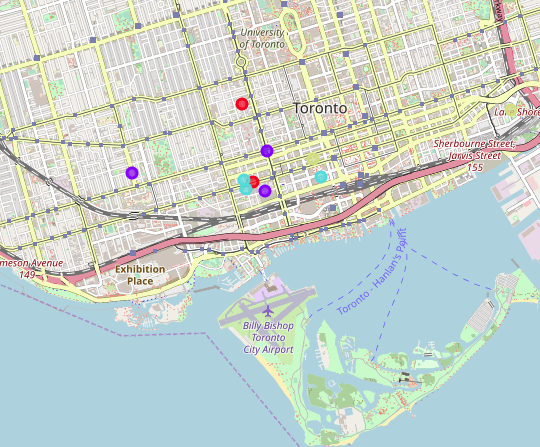